In [1]:
import os, sys
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from torch.utils.data import DataLoader, random_split
import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
import anndata
import pickle

script_dir = Path().resolve()
repo_dir = script_dir
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
sys.path.append(str(src_dir))
sys.path.append(str(data_dir))

from dataset.read_scrnaseq_data import read_cell_by_gene_matrix, convert_cell_by_gene_matrix_to_anndata, read_hires_metadata_file, ensure_same_genes_in_dataframes
from dataset.preprocessing import scrna_seq_normalization
from dataset.dataloader import AnnDataDataset
from dataset.precompute_scrnaseq_data import *

from model.scRNA_AE import scRNASeqAE
from model.scRNA_E_C import scRNASeqE_simCLR, scRNASeqEncoder, scRNASeqDecoder, scRNASeqProjectionHead, scRNASeqE_VICReg, scRNASeqE_VICRegLarge, scRNASeqE_VICRegExpanderLarge, scRNASeqE_VICRegExpander


PARAMETERS = {
    'hvgs': 20116,
    'num_genes': 20116,
    'latent_dimension': 50,
    'target_sum': 10000,
    'batch_size': 1024,
    'num_epochs': 5,
}

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['figure.dpi'] = 600
plt.rcParams["figure.figsize"] = (12, 8)

seed_everything(1)

[rank: 0] Seed set to 1


1

In [2]:
def plot_legend_only(adata, color_key, save_path, ncols=1):
    # 1. Create the UMAP plot (with a valid legend location) but do not display it.
    ax = sc.pl.umap(
        adata, 
        color=color_key, 
        legend_loc='right margin',  # ensures a legend is created
        title='',
        frameon=False,
        show=False
    )

    # 2. Extract legend handles and labels from the resulting axes
    handles, labels = ax.get_legend_handles_labels()
    plt.close(ax.figure)

    # 3. Create a new figure that plots ONLY the legend
    fig, ax_leg = plt.subplots(figsize=(12, 8))
    ax_leg.legend(
        handles, 
        labels, 
        loc='center', 
        ncols=ncols, 
        frameon=False, 
        prop={'size': 24},   # Increase the font size
        markerscale=3        # Increase the marker size in the legend
    )
    ax_leg.axis('off')  # Remove the axes for a clean legend-only figure

    # 4. Save and display the legend-only figure
    fig.savefig(save_path)
    plt.close(fig)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# checkpoint_path=r'VICReg_experiments/best_trial_results/v2/checkpoints/genes20116_batch2048_ctCS_ctmsgG_DO_ctRS_gSS_epoch=109-val_loss=0.5884.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=177-val_loss=0.4375.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=196-val_loss=0.4714.ckpt'

# v3,5
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_ctCS_ctmsgG_DO_ctRS_gSS_epoch=334-val_loss=0.8472.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_gRS_gSS_epoch=112-val_loss=0.4803.ckpt' #prev best
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent50_ctCS_ctmsgG_DO_ctRS_gSS_epoch=97-val_loss=0.3729.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_gRS_ctRS_gSS_epoch=98-val_loss=7.9260.ckpt'

# v3,5 ExpanderLarge
# checkpoint_path=r'VICRegExpanderLarge_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=743-val_loss=8.7914.ckpt'
# v3_5_zeroshot_VICReg_model = scRNASeqE_VICRegExpanderLarge.load_from_checkpoint(checkpoint_path=checkpoint_path)

#v3,5 Expander
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_gG_ctmsgG_DO_ctRS_gSS_epoch=71-val_loss=22.2740 copy.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_gG_ctmsgG_DO_ctRS_gSS_epoch=606-val_loss=17.1812.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=938-val_loss=7.2107.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent64_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=968-val_loss=5.7642.ckpt'
checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=8.8825.ckpt'

v3_5_zeroshot_VICReg_model = scRNASeqE_VICRegExpander.load_from_checkpoint(checkpoint_path=checkpoint_path)


v3_5_zeroshot_VICReg_model.to(device)
v3_5_zeroshot_VICReg_model.eval()

scRNASeqE_VICRegExpander(
  (encoder): scRNASeqEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=20116, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (projector): scRNASeqProjectionHeadExpander(
    (projectionHead): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=256, bias=True)


In [87]:
from pytorch_lightning.utilities.model_summary import summarize

summarize(v3_5_zeroshot_VICReg_model)

  | Name           | Type                           | Params | Mode
-------------------------------------------------------------------------
0 | encoder        | scRNASeqEncoder                | 5.2 M  | eval
1 | projector      | scRNASeqProjectionHeadExpander | 165 K  | eval
2 | vicreg_loss_fn | VICRegLoss                     | 0      | eval
-------------------------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.463    Total estimated model params size (MB)
0         Modules in train mode
19        Modules in eval mode

### Tabula muris

In [3]:
VERSION = 'v3,5'
tm_adata_train_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_train_{VERSION}.pkl'
with open(tm_adata_train_path, 'rb') as f:
    tm_adata_train = pickle.load(f)
tm_adata_train = tm_adata_train.copy()

tm_adata_test_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_test_{VERSION}.pkl'
with open(tm_adata_test_path, 'rb') as f:
    tm_adata_test = pickle.load(f)
tm_adata_test = tm_adata_test.copy()

embryo_adata_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned.pkl'
with open(embryo_adata_path, 'rb') as f:
    embryo_adata = pickle.load(f)
embryo_adata = embryo_adata.copy()

brain_adata_path = data_dir / 'pickled' / 'HiRES' / 'brain_adata_tm_aligned.pkl'
with open(brain_adata_path, 'rb') as f:
    brain_adata = pickle.load(f)
brain_adata = brain_adata.copy()

In [20]:
# tm_adata_train.obs['tissue']
embryo_adata

AnnData object with n_obs × n_vars = 7469 × 20116
    obs: 'Rawreads', 'DNAreads', 'RNAreads', 'y/x', 'Raw contacts', 'Dedup contacts', 'Clean1 contacts', 'Clean2 contacts', 'Clean3 contacts', 'Clean3 inter-contacts', 'Genes number', 'UMI counts', 'near%', 'mitotic%', 'farAvg', 'repli score', 'G1S.Score', 'G2M.Score', 'Stage', 'Celltype', 'RMSD 20k', 'CDPS cluster', 'Sub_k_cluster', 'Cellcycle phase'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [21]:
with torch.no_grad():
    latent_representations = v3_5_zeroshot_VICReg_model.encoder(
        torch.tensor(tm_adata_test.X.toarray(), dtype=torch.float32).to(device)
        )

latent_np_encoder = latent_representations.detach().cpu().numpy()
TM_ZEROSHOT_KEY = 'X_VICReg_zeroshot_v3_5_latent'
tm_adata_test.obsm[TM_ZEROSHOT_KEY] = latent_np_encoder
tm_adata_test.uns.pop('Celltype_colors', None)


sc.pp.neighbors(tm_adata_test, use_rep=TM_ZEROSHOT_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

In [19]:
tm_adata_test

AnnData object with n_obs × n_vars = 61774 × 20116
    obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability', '_scvi_batch', '_scvi_labels', 'kmeans_pca'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'pca'
    obsm: 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

#### All test tissues

In [237]:
output_folder = r'./create_figures/figures_v3,5/expander/scContrast/tabula_muris'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/test_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/test_tech.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/test_availability.png')
# plt.close(fig)

In [59]:
plot_legend_only(tm_adata_test, 'Celltype', f'{output_folder}/test_celltypes_legend.png', ncols=2)
plot_legend_only(tm_adata_test, 'tech', f'{output_folder}/test_tech_legend.png')
plot_legend_only(tm_adata_test, 'celltype_tech_availability', f'{output_folder}/test_availability_legend.png')

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
sil_score_true = silhouette_score(tm_adata_test.obsm[TM_ZEROSHOT_KEY], tm_adata_test.obs["Celltype"])
print(f"Silhouette Score (TM_ZEROSHOT_KEY): {sil_score_true:.4f}")

n_clusters = len(tm_adata_test.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
tm_adata_test.obs["kmeans_clusters"] = kmeans.fit_predict(tm_adata_test.obsm[TM_ZEROSHOT_KEY]).astype(str)
sc.pp.neighbors(tm_adata_test, use_rep=TM_ZEROSHOT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(tm_adata_test, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = tm_adata_test.obs["Celltype"].values  # True cell types
predicted_labels = tm_adata_test.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for TM_ZEROSHOT_KEY Clustering: {ari_score:.4f}")



#### Single-tissue

In [73]:
tm_adata_test = tm_adata_test.copy()
TISSUE = 'Limb_Muscle'
tm_adata_test_tissue_only = tm_adata_test[tm_adata_test.obs['tissue']==TISSUE].copy()
tm_adata_test_tissue_only.uns.pop('Celltype_colors', None)

In [74]:
output_folder = r'./create_figures/figures_v3,5/expander/scContrast/tabula_muris'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test_tissue_only, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/celltypes_{TISSUE}.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test_tissue_only, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/tech_{TISSUE}.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test_tissue_only, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/availability_{TISSUE}.png')
# plt.close(fig)

In [75]:
plot_legend_only(tm_adata_test_tissue_only, 'Celltype', f'{output_folder}/celltypes_{TISSUE}_legend.png')
plot_legend_only(tm_adata_test_tissue_only, 'tech', f'{output_folder}/tech_{TISSUE}_legend.png')
plot_legend_only(tm_adata_test_tissue_only, 'celltype_tech_availability', f'{output_folder}/availability_{TISSUE}_legend.png')

In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print(TISSUE)
sil_score_true = silhouette_score(tm_adata_test_tissue_only.obsm[TM_ZEROSHOT_KEY], tm_adata_test_tissue_only.obs["Celltype"])
print(f"Silhouette Score (TM_ZEROSHOT_KEY): {sil_score_true:.4f}")

n_clusters = len(tm_adata_test_tissue_only.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
tm_adata_test_tissue_only.obs["kmeans_clusters"] = kmeans.fit_predict(tm_adata_test_tissue_only.obsm[TM_ZEROSHOT_KEY]).astype(str)
sc.pp.neighbors(tm_adata_test_tissue_only, use_rep=TM_ZEROSHOT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(tm_adata_test_tissue_only, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = tm_adata_test_tissue_only.obs["Celltype"].values  # True cell types
predicted_labels = tm_adata_test_tissue_only.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for TM_ZEROSHOT_KEY Clustering: {ari_score:.4f}")



#### scANVI comparisons

In [6]:
import os
import tempfile

import scanpy as sc
from importlib import reload
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

In [7]:
VERSION = 'v3,5'
tm_adata_train_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_train_{VERSION}.pkl'
with open(tm_adata_train_path, 'rb') as f:
    tm_adata_train = pickle.load(f)
tm_adata_train = tm_adata_train.copy()

tm_adata_test_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_test_{VERSION}.pkl'
with open(tm_adata_test_path, 'rb') as f:
    tm_adata_test = pickle.load(f)
tm_adata_test = tm_adata_test.copy()

embryo_adata_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned.pkl'
with open(embryo_adata_path, 'rb') as f:
    embryo_adata = pickle.load(f)
embryo_adata = embryo_adata.copy()

brain_adata_path = data_dir / 'pickled' / 'HiRES' / 'brain_adata_tm_aligned.pkl'
with open(brain_adata_path, 'rb') as f:
    brain_adata = pickle.load(f)
brain_adata = brain_adata.copy()

In [8]:
tm_adata_test.layers["counts"] = tm_adata_test.X.copy()

In [9]:
scvi.model.SCVI.setup_anndata(tm_adata_test, layer="counts", batch_key="tech")

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [10]:
scvi_model = scvi.model.SCVI(tm_adata_test, n_layers=3, n_latent=128)

In [11]:
scvi_model.train()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/130:   0%|                                                                                                                                                           | 0/130 [00:00<?, ?it/s]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/130:   1%|▋                                                                                      | 1/130 [00:07<17:01,  7.92s/it, v_num=1, train_loss_step=4.74e+3, train_loss_epoch=5.08e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/130:   2%|█▎                                                                                     | 2/130 [00:15<16:01,  7.51s/it, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.68e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/130:   2%|██                                                                                     | 3/130 [00:22<15:38,  7.39s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.58e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/130:   3%|██▋                                                                                    | 4/130 [00:29<15:23,  7.33s/it, v_num=1, train_loss_step=4.52e+3, train_loss_epoch=4.52e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/130:   4%|███▎                                                                                   | 5/130 [00:36<15:13,  7.31s/it, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.47e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/130:   5%|████                                                                                   | 6/130 [00:44<15:05,  7.30s/it, v_num=1, train_loss_step=4.56e+3, train_loss_epoch=4.43e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/130:   5%|████▋                                                                                  | 7/130 [00:51<14:54,  7.27s/it, v_num=1, train_loss_step=4.55e+3, train_loss_epoch=4.41e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/130:   6%|█████▎                                                                                 | 8/130 [00:58<14:44,  7.25s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.38e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/130:   7%|█████▉                                                                                | 9/130 [01:05<14:34,  7.23s/it, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.37e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/130:   8%|██████▌                                                                              | 10/130 [01:12<14:26,  7.22s/it, v_num=1, train_loss_step=4.31e+3, train_loss_epoch=4.35e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/130:   8%|███████▏                                                                             | 11/130 [01:20<14:17,  7.21s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.34e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/130:   9%|███████▊                                                                             | 12/130 [01:27<14:09,  7.20s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.33e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/130:  10%|████████▌                                                                            | 13/130 [01:34<14:01,  7.19s/it, v_num=1, train_loss_step=4.42e+3, train_loss_epoch=4.32e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/130:  11%|█████████▏                                                                           | 14/130 [01:41<13:53,  7.18s/it, v_num=1, train_loss_step=4.45e+3, train_loss_epoch=4.31e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/130:  12%|█████████▊                                                                           | 15/130 [01:48<13:44,  7.17s/it, v_num=1, train_loss_step=4.38e+3, train_loss_epoch=4.31e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/130:  12%|██████████▌                                                                           | 16/130 [01:55<13:36,  7.16s/it, v_num=1, train_loss_step=4.57e+3, train_loss_epoch=4.3e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/130:  13%|███████████▏                                                                          | 17/130 [02:03<13:27,  7.14s/it, v_num=1, train_loss_step=4.22e+3, train_loss_epoch=4.3e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/130:  14%|███████████▊                                                                         | 18/130 [02:10<13:19,  7.13s/it, v_num=1, train_loss_step=4.03e+3, train_loss_epoch=4.29e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/130:  15%|████████████▍                                                                        | 19/130 [02:17<13:10,  7.12s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=4.29e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/130:  15%|█████████████                                                                        | 20/130 [02:24<13:01,  7.11s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.28e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/130:  16%|█████████████▋                                                                       | 21/130 [02:31<12:52,  7.09s/it, v_num=1, train_loss_step=4.41e+3, train_loss_epoch=4.28e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/130:  17%|██████████████▍                                                                      | 22/130 [02:38<12:44,  7.08s/it, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.28e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/130:  18%|███████████████▏                                                                      | 23/130 [02:45<12:35,  7.06s/it, v_num=1, train_loss_step=4.5e+3, train_loss_epoch=4.28e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/130:  18%|███████████████▋                                                                     | 24/130 [02:52<12:28,  7.06s/it, v_num=1, train_loss_step=4.52e+3, train_loss_epoch=4.27e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/130:  19%|████████████████▎                                                                    | 25/130 [02:59<12:20,  7.05s/it, v_num=1, train_loss_step=4.22e+3, train_loss_epoch=4.27e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/130:  20%|█████████████████                                                                    | 26/130 [03:06<12:12,  7.05s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.27e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/130:  21%|█████████████████▋                                                                   | 27/130 [03:13<12:04,  7.03s/it, v_num=1, train_loss_step=4.41e+3, train_loss_epoch=4.27e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/130:  22%|██████████████████▎                                                                  | 28/130 [03:20<11:56,  7.02s/it, v_num=1, train_loss_step=4.25e+3, train_loss_epoch=4.27e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/130:  22%|███████████████████▏                                                                  | 29/130 [03:27<11:48,  7.02s/it, v_num=1, train_loss_step=4.3e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/130:  23%|███████████████████▌                                                                 | 30/130 [03:34<11:40,  7.01s/it, v_num=1, train_loss_step=4.23e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/130:  24%|████████████████████▎                                                                | 31/130 [03:41<11:32,  7.00s/it, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/130:  25%|████████████████████▉                                                                | 32/130 [03:48<11:25,  6.99s/it, v_num=1, train_loss_step=4.35e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/130:  25%|█████████████████████▌                                                               | 33/130 [03:55<11:17,  6.98s/it, v_num=1, train_loss_step=4.16e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/130:  26%|██████████████████████▏                                                              | 34/130 [04:02<11:10,  6.98s/it, v_num=1, train_loss_step=4.53e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/130:  27%|███████████████████████▏                                                              | 35/130 [04:09<11:03,  6.98s/it, v_num=1, train_loss_step=4.4e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/130:  28%|███████████████████████▌                                                             | 36/130 [04:16<10:56,  6.98s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.26e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/130:  28%|████████████████████████▏                                                            | 37/130 [04:23<10:49,  6.98s/it, v_num=1, train_loss_step=4.47e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/130:  29%|████████████████████████▊                                                            | 38/130 [04:30<10:42,  6.99s/it, v_num=1, train_loss_step=3.92e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/130:  30%|█████████████████████████▌                                                           | 39/130 [04:37<10:36,  6.99s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/130:  31%|██████████████████████████▏                                                          | 40/130 [04:44<10:29,  6.99s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/130:  32%|██████████████████████████▊                                                          | 41/130 [04:51<10:22,  6.99s/it, v_num=1, train_loss_step=4.28e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/130:  32%|███████████████████████████▍                                                         | 42/130 [04:58<10:15,  6.99s/it, v_num=1, train_loss_step=4.46e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/130:  33%|████████████████████████████                                                         | 43/130 [05:05<10:07,  6.99s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/130:  34%|████████████████████████████▊                                                        | 44/130 [05:12<10:00,  6.99s/it, v_num=1, train_loss_step=3.91e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/130:  35%|█████████████████████████████▍                                                       | 45/130 [05:19<09:53,  6.98s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/130:  35%|██████████████████████████████                                                       | 46/130 [05:26<09:46,  6.99s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/130:  36%|██████████████████████████████▋                                                      | 47/130 [05:33<09:40,  6.99s/it, v_num=1, train_loss_step=4.45e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/130:  37%|███████████████████████████████▍                                                     | 48/130 [05:40<09:33,  6.99s/it, v_num=1, train_loss_step=4.28e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/130:  38%|████████████████████████████████                                                     | 49/130 [05:47<09:26,  6.99s/it, v_num=1, train_loss_step=4.18e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 51/130:  38%|████████████████████████████████▋                                                    | 50/130 [05:54<09:19,  7.00s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 52/130:  39%|█████████████████████████████████▎                                                   | 51/130 [06:01<09:12,  7.00s/it, v_num=1, train_loss_step=4.38e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 53/130:  40%|██████████████████████████████████                                                   | 52/130 [06:08<09:05,  7.00s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 54/130:  41%|██████████████████████████████████▋                                                  | 53/130 [06:15<08:58,  6.99s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 55/130:  42%|███████████████████████████████████▎                                                 | 54/130 [06:22<08:51,  6.99s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 56/130:  42%|███████████████████████████████████▉                                                 | 55/130 [06:29<08:44,  6.99s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 57/130:  43%|████████████████████████████████████▌                                                | 56/130 [06:36<08:37,  7.00s/it, v_num=1, train_loss_step=4.35e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 58/130:  44%|█████████████████████████████████████▎                                               | 57/130 [06:43<08:31,  7.01s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 59/130:  45%|█████████████████████████████████████▉                                               | 58/130 [06:50<08:24,  7.01s/it, v_num=1, train_loss_step=4.19e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 60/130:  45%|██████████████████████████████████████▌                                              | 59/130 [06:57<08:17,  7.01s/it, v_num=1, train_loss_step=4.22e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 61/130:  46%|███████████████████████████████████████▏                                             | 60/130 [07:04<08:10,  7.01s/it, v_num=1, train_loss_step=4.34e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 62/130:  47%|███████████████████████████████████████▉                                             | 61/130 [07:11<08:04,  7.02s/it, v_num=1, train_loss_step=4.23e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 63/130:  48%|████████████████████████████████████████▌                                            | 62/130 [07:18<07:56,  7.01s/it, v_num=1, train_loss_step=4.38e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 64/130:  48%|█████████████████████████████████████████▏                                           | 63/130 [07:25<07:49,  7.01s/it, v_num=1, train_loss_step=4.18e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 65/130:  49%|██████████████████████████████████████████▎                                           | 64/130 [07:32<07:42,  7.01s/it, v_num=1, train_loss_step=4.3e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 66/130:  50%|██████████████████████████████████████████▌                                          | 65/130 [07:39<07:35,  7.00s/it, v_num=1, train_loss_step=4.16e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 67/130:  51%|███████████████████████████████████████████▏                                         | 66/130 [07:46<07:27,  7.00s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 68/130:  52%|███████████████████████████████████████████▊                                         | 67/130 [07:53<07:20,  6.99s/it, v_num=1, train_loss_step=4.27e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 69/130:  52%|████████████████████████████████████████████▍                                        | 68/130 [08:00<07:13,  6.99s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 70/130:  53%|█████████████████████████████████████████████                                        | 69/130 [08:07<07:06,  6.98s/it, v_num=1, train_loss_step=4.27e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 71/130:  54%|█████████████████████████████████████████████▊                                       | 70/130 [08:14<06:58,  6.98s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 72/130:  55%|██████████████████████████████████████████████▍                                      | 71/130 [08:21<06:51,  6.98s/it, v_num=1, train_loss_step=4.03e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 73/130:  55%|███████████████████████████████████████████████                                      | 72/130 [08:28<06:44,  6.97s/it, v_num=1, train_loss_step=4.11e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 74/130:  56%|███████████████████████████████████████████████▋                                     | 73/130 [08:35<06:37,  6.97s/it, v_num=1, train_loss_step=4.27e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 75/130:  57%|████████████████████████████████████████████████▍                                    | 74/130 [08:42<06:30,  6.97s/it, v_num=1, train_loss_step=3.89e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 76/130:  58%|█████████████████████████████████████████████████                                    | 75/130 [08:49<06:23,  6.97s/it, v_num=1, train_loss_step=4.24e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 77/130:  58%|█████████████████████████████████████████████████▋                                   | 76/130 [08:56<06:16,  6.97s/it, v_num=1, train_loss_step=4.49e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 78/130:  59%|██████████████████████████████████████████████████▎                                  | 77/130 [09:03<06:09,  6.97s/it, v_num=1, train_loss_step=4.41e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 79/130:  60%|███████████████████████████████████████████████████                                  | 78/130 [09:10<06:02,  6.97s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/130:  61%|███████████████████████████████████████████████████▋                                 | 79/130 [09:17<05:55,  6.97s/it, v_num=1, train_loss_step=4.24e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 81/130:  62%|████████████████████████████████████████████████████▎                                | 80/130 [09:23<05:48,  6.97s/it, v_num=1, train_loss_step=4.16e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 82/130:  62%|████████████████████████████████████████████████████▉                                | 81/130 [09:30<05:41,  6.97s/it, v_num=1, train_loss_step=4.23e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 83/130:  63%|█████████████████████████████████████████████████████▌                               | 82/130 [09:37<05:34,  6.97s/it, v_num=1, train_loss_step=4.27e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 84/130:  64%|██████████████████████████████████████████████████████▎                              | 83/130 [09:44<05:28,  6.98s/it, v_num=1, train_loss_step=3.93e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 85/130:  65%|███████████████████████████████████████████████████████▌                              | 84/130 [09:51<05:21,  6.98s/it, v_num=1, train_loss_step=4.3e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 86/130:  65%|███████████████████████████████████████████████████████▌                             | 85/130 [09:58<05:13,  6.98s/it, v_num=1, train_loss_step=4.04e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 87/130:  66%|████████████████████████████████████████████████████████▏                            | 86/130 [10:05<05:06,  6.97s/it, v_num=1, train_loss_step=4.27e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 88/130:  67%|████████████████████████████████████████████████████████▉                            | 87/130 [10:12<04:59,  6.98s/it, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 89/130:  68%|█████████████████████████████████████████████████████████▌                           | 88/130 [10:19<04:52,  6.97s/it, v_num=1, train_loss_step=4.23e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 90/130:  68%|██████████████████████████████████████████████████████████▏                          | 89/130 [10:26<04:45,  6.97s/it, v_num=1, train_loss_step=4.38e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 91/130:  69%|██████████████████████████████████████████████████████████▊                          | 90/130 [10:33<04:38,  6.97s/it, v_num=1, train_loss_step=4.18e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 92/130:  70%|███████████████████████████████████████████████████████████▍                         | 91/130 [10:40<04:31,  6.96s/it, v_num=1, train_loss_step=4.27e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 93/130:  71%|████████████████████████████████████████████████████████████▏                        | 92/130 [10:47<04:24,  6.96s/it, v_num=1, train_loss_step=4.18e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 94/130:  72%|████████████████████████████████████████████████████████████▊                        | 93/130 [10:54<04:17,  6.96s/it, v_num=1, train_loss_step=4.19e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 95/130:  72%|█████████████████████████████████████████████████████████████▍                       | 94/130 [11:01<04:10,  6.96s/it, v_num=1, train_loss_step=3.99e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 96/130:  73%|██████████████████████████████████████████████████████████████                       | 95/130 [11:08<04:03,  6.95s/it, v_num=1, train_loss_step=4.15e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 97/130:  74%|██████████████████████████████████████████████████████████████▊                      | 96/130 [11:15<03:56,  6.96s/it, v_num=1, train_loss_step=4.38e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 98/130:  75%|███████████████████████████████████████████████████████████████▍                     | 97/130 [11:22<03:49,  6.97s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 99/130:  75%|████████████████████████████████████████████████████████████████                     | 98/130 [11:29<03:43,  6.97s/it, v_num=1, train_loss_step=3.99e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/130:  76%|███████████████████████████████████████████████████████████████▉                    | 99/130 [11:36<03:36,  6.98s/it, v_num=1, train_loss_step=4.03e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 101/130:  77%|████████████████████████████████████████████████████████████████▌                   | 100/130 [11:43<03:29,  6.98s/it, v_num=1, train_loss_step=4.4e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 102/130:  78%|████████████████████████████████████████████████████████████████▍                  | 101/130 [11:50<03:22,  6.98s/it, v_num=1, train_loss_step=4.15e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 103/130:  78%|█████████████████████████████████████████████████████████████████                  | 102/130 [11:57<03:15,  6.98s/it, v_num=1, train_loss_step=4.31e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 104/130:  79%|█████████████████████████████████████████████████████████████████▊                 | 103/130 [12:04<03:08,  6.98s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 105/130:  80%|██████████████████████████████████████████████████████████████████▍                | 104/130 [12:11<03:01,  6.98s/it, v_num=1, train_loss_step=4.43e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 106/130:  81%|███████████████████████████████████████████████████████████████████                | 105/130 [12:18<02:54,  6.98s/it, v_num=1, train_loss_step=4.28e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 107/130:  82%|███████████████████████████████████████████████████████████████████▋               | 106/130 [12:25<02:47,  6.98s/it, v_num=1, train_loss_step=3.88e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 108/130:  82%|████████████████████████████████████████████████████████████████████▎              | 107/130 [12:32<02:40,  6.98s/it, v_num=1, train_loss_step=4.16e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 109/130:  83%|████████████████████████████████████████████████████████████████████▉              | 108/130 [12:39<02:33,  6.98s/it, v_num=1, train_loss_step=4.07e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 110/130:  84%|█████████████████████████████████████████████████████████████████████▌             | 109/130 [12:46<02:26,  6.98s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 111/130:  85%|██████████████████████████████████████████████████████████████████████▏            | 110/130 [12:53<02:19,  6.98s/it, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 112/130:  85%|██████████████████████████████████████████████████████████████████████▊            | 111/130 [13:00<02:12,  6.98s/it, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 113/130:  86%|███████████████████████████████████████████████████████████████████████▌           | 112/130 [13:07<02:05,  6.98s/it, v_num=1, train_loss_step=4.09e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 114/130:  87%|████████████████████████████████████████████████████████████████████████▏          | 113/130 [13:14<01:58,  6.98s/it, v_num=1, train_loss_step=4.23e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 115/130:  88%|████████████████████████████████████████████████████████████████████████▊          | 114/130 [13:21<01:51,  6.97s/it, v_num=1, train_loss_step=4.22e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 116/130:  88%|█████████████████████████████████████████████████████████████████████████▍         | 115/130 [13:28<01:44,  6.97s/it, v_num=1, train_loss_step=4.36e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 117/130:  89%|██████████████████████████████████████████████████████████████████████████         | 116/130 [13:35<01:37,  6.98s/it, v_num=1, train_loss_step=4.24e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 118/130:  90%|██████████████████████████████████████████████████████████████████████████▋        | 117/130 [13:42<01:30,  6.98s/it, v_num=1, train_loss_step=4.19e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 119/130:  91%|███████████████████████████████████████████████████████████████████████████▎       | 118/130 [13:49<01:23,  6.98s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 120/130:  92%|███████████████████████████████████████████████████████████████████████████▉       | 119/130 [13:56<01:16,  6.99s/it, v_num=1, train_loss_step=4.15e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 121/130:  92%|████████████████████████████████████████████████████████████████████████████▌      | 120/130 [14:03<01:09,  6.99s/it, v_num=1, train_loss_step=4.13e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 122/130:  93%|██████████████████████████████████████████████████████████████████████████████▏     | 121/130 [14:10<01:02,  6.99s/it, v_num=1, train_loss_step=4.2e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 123/130:  94%|█████████████████████████████████████████████████████████████████████████████▉     | 122/130 [14:17<00:55,  7.00s/it, v_num=1, train_loss_step=4.14e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 124/130:  95%|██████████████████████████████████████████████████████████████████████████████▌    | 123/130 [14:24<00:49,  7.00s/it, v_num=1, train_loss_step=4.05e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 125/130:  95%|███████████████████████████████████████████████████████████████████████████████▏   | 124/130 [14:31<00:42,  7.00s/it, v_num=1, train_loss_step=4.25e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 126/130:  96%|███████████████████████████████████████████████████████████████████████████████▊   | 125/130 [14:38<00:34,  7.00s/it, v_num=1, train_loss_step=4.35e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 127/130:  97%|█████████████████████████████████████████████████████████████████████████████████▍  | 126/130 [14:45<00:27,  6.99s/it, v_num=1, train_loss_step=4.1e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 128/130:  98%|█████████████████████████████████████████████████████████████████████████████████  | 127/130 [14:51<00:20,  6.99s/it, v_num=1, train_loss_step=4.17e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 129/130:  98%|█████████████████████████████████████████████████████████████████████████████████▋ | 128/130 [14:58<00:13,  6.97s/it, v_num=1, train_loss_step=4.25e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 130/130:  99%|██████████████████████████████████████████████████████████████████████████████████▎| 129/130 [15:05<00:06,  6.97s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.23e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 130/130: 100%|███████████████████████████████████████████████████████████████████████████████████| 130/130 [15:12<00:00,  6.98s/it, v_num=1, train_loss_step=4.45e+3, train_loss_epoch=4.23e+3]

`Trainer.fit` stopped: `max_epochs=130` reached.


Epoch 130/130: 100%|███████████████████████████████████████████████████████████████████████████████████| 130/130 [15:12<00:00,  7.02s/it, v_num=1, train_loss_step=4.45e+3, train_loss_epoch=4.23e+3]


In [12]:
SCVI_LATENT_KEY = "X_scVI"
tm_adata_test.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [64]:
sc.pp.neighbors(tm_adata_test, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(tm_adata_test)

###### Default scVI

In [15]:
## default settings
scvi_model_default = scvi.model.SCVI(tm_adata_test)

In [16]:
scvi_model_default.train()

In [17]:
SCVI_DEFAULT_LATENT_KEY = "X_scVI_default"
tm_adata_test.obsm[SCVI_DEFAULT_LATENT_KEY] = scvi_model.get_latent_representation()

In [18]:
sc.pp.neighbors(tm_adata_test, use_rep=SCVI_DEFAULT_LATENT_KEY)
sc.tl.umap(tm_adata_test)

##### All Tissues

In [65]:
output_folder = r'./create_figures/figures_v3,5alt/scVI'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='Celltype', legend_loc=None, title='', frameon=False, size=15, return_fig=True)
fig.savefig(f'{output_folder}/tm_test_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=15, return_fig=True)
fig.savefig(f'{output_folder}/tm_test_tech.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=15, return_fig=True)
fig.savefig(f'{output_folder}/tm_test_availability.png')
# plt.close(fig)

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print('ALL TISSUES')
sil_score_true = silhouette_score(tm_adata_test.obsm[SCVI_LATENT_KEY], tm_adata_test.obs["Celltype"])
print(f"Silhouette Score ({SCVI_LATENT_KEY}): {sil_score_true:.4f}")

n_clusters = len(tm_adata_test.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
tm_adata_test.obs["kmeans_clusters"] = kmeans.fit_predict(tm_adata_test.obsm[SCVI_LATENT_KEY]).astype(str)
sc.pp.neighbors(tm_adata_test, use_rep=SCVI_LATENT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(tm_adata_test, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = tm_adata_test.obs["Celltype"].values  # True cell types
predicted_labels = tm_adata_test.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for {SCVI_LATENT_KEY} Clustering: {ari_score:.4f}")



ALL TISSUES

Silhouette Score (X_scVI): 0.1276

/tmp/ipykernel_2402054/3377774372.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(tm_adata_test, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering


ARI for X_scVI Clustering: 0.4105

##### Single Tissue

In [75]:
TISSUE = 'Pancreas'
tm_adata_test_tissue_only = tm_adata_test[tm_adata_test.obs['tissue']==TISSUE].copy()
tm_adata_test_tissue_only.uns.pop('Celltype_colors', None)

array(['#63ffac', '#6a3a4c', '#61615a', '#ba0900', '#6b7900', '#00c2a0',
       '#ffaa92', '#ff90c9', '#b903aa'], dtype='<U7')

In [76]:
output_folder = r'./create_figures/figures_v3,5alt/scVI'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test_tissue_only, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/{TISSUE}_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test_tissue_only, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/{TISSUE}_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test_tissue_only, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/{TISSUE}_availability.png')
plt.close(fig)

In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print(f'{TISSUE=}')
sil_score_true = silhouette_score(tm_adata_test_tissue_only.obsm[SCVI_LATENT_KEY], tm_adata_test_tissue_only.obs["Celltype"])
print(f"Silhouette Score ({SCVI_LATENT_KEY}): {sil_score_true:.4f}")

n_clusters = len(tm_adata_test_tissue_only.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
tm_adata_test_tissue_only.obs["kmeans_clusters"] = kmeans.fit_predict(tm_adata_test_tissue_only.obsm[SCVI_LATENT_KEY]).astype(str)
sc.pp.neighbors(tm_adata_test_tissue_only, use_rep=SCVI_LATENT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(tm_adata_test_tissue_only, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = tm_adata_test_tissue_only.obs["Celltype"].values  # True cell types
predicted_labels = tm_adata_test_tissue_only.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for {SCVI_LATENT_KEY} Clustering: {ari_score:.4f}")



TISSUE='Pancreas'

Silhouette Score (X_scVI): 0.2638

ARI for X_scVI Clustering: 0.5066

##### scANVI

In [58]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=tm_adata_test,
    labels_key="Celltype",
    unlabeled_category="Unknown",
)

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 9 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 9 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [59]:
scanvi_model.train()

INFO     Training for 10 epochs.                                                                                   


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/10:  10%|████████▉                                                                                | 1/10 [00:16<02:30, 16.68s/it, v_num=1, train_loss_step=4.39e+3, train_loss_epoch=4.27e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 3/10:  20%|█████████████████▊                                                                       | 2/10 [00:34<02:17, 17.25s/it, v_num=1, train_loss_step=4.32e+3, train_loss_epoch=4.25e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 4/10:  30%|██████████████████████████▋                                                              | 3/10 [00:51<01:59, 17.07s/it, v_num=1, train_loss_step=4.29e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 5/10:  40%|███████████████████████████████████▌                                                     | 4/10 [01:09<01:44, 17.45s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 6/10:  50%|████████████████████████████████████████████▌                                            | 5/10 [01:26<01:26, 17.25s/it, v_num=1, train_loss_step=4.37e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 7/10:  60%|██████████████████████████████████████████████████████                                    | 6/10 [01:43<01:08, 17.21s/it, v_num=1, train_loss_step=4.3e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 8/10:  70%|██████████████████████████████████████████████████████████████▉                           | 7/10 [02:00<00:51, 17.11s/it, v_num=1, train_loss_step=4.2e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 9/10:  80%|███████████████████████████████████████████████████████████████████████▏                 | 8/10 [02:17<00:34, 17.10s/it, v_num=1, train_loss_step=4.38e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 10/10:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 9/10 [02:34<00:17, 17.04s/it, v_num=1, train_loss_step=4.28e+3, train_loss_epoch=4.24e+3]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:51<00:00, 17.09s/it, v_num=1, train_loss_step=3.9e+3, train_loss_epoch=4.24e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:51<00:00, 17.13s/it, v_num=1, train_loss_step=3.9e+3, train_loss_epoch=4.24e+3]


In [60]:
SCANVI_LATENT_KEY = "X_scANVI"
tm_adata_test.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(tm_adata_test)

In [85]:
sc.pp.neighbors(tm_adata_test, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(tm_adata_test)

In [86]:
output_folder = r'./create_figures/figures_v3,5alt/scVI'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='Celltype', legend_loc=None, title='', frameon=False, size=15, return_fig=True)
fig.savefig(f'{output_folder}/tm_test_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=15, return_fig=True)
fig.savefig(f'{output_folder}/tm_test_tech.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=15, return_fig=True)
fig.savefig(f'{output_folder}/tm_test_availability.png')
# plt.close(fig)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print('ALL TISSUES')
sil_score_true = silhouette_score(tm_adata_test.obsm[SCANVI_LATENT_KEY], tm_adata_test.obs["Celltype"])
print(f"Silhouette Score ({SCANVI_LATENT_KEY}): {sil_score_true:.4f}")

n_clusters = len(tm_adata_test.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
tm_adata_test.obs["kmeans_clusters"] = kmeans.fit_predict(tm_adata_test.obsm[SCANVI_LATENT_KEY]).astype(str)
sc.pp.neighbors(tm_adata_test, use_rep=SCANVI_LATENT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(tm_adata_test, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = tm_adata_test.obs["Celltype"].values  # True cell types
predicted_labels = tm_adata_test.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for {SCANVI_LATENT_KEY} Clustering: {ari_score:.4f}")



ALL TISSUES

Silhouette Score (X_scANVI): 0.1948

ARI for X_scANVI Clustering: 0.4533

In [ ]:
TISSUE = 'Skin'
tm_adata_test_tissue_only = tm_adata_test[tm_adata_test.obs['tissue']==TISSUE].copy()

In [ ]:
output_folder = r'./create_figures/figures_v3,5alt/scANVI'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test_tissue_only, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/scANVI_v3_{TISSUE}_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test_tissue_only, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/scANVI_v3_{TISSUE}_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test_tissue_only, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/scANVI_v3_{TISSUE}_availability.png')
plt.close(fig)

#### scIB Benchmark

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
n_clusters = len(tm_adata_test.obs["Celltype"].unique())

PCA_LATENT_KEY = 'X_pca'

sc.tl.pca(tm_adata_test)
# Apply K-Means clustering on PCA embeddings
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
tm_adata_test.obs["kmeans_pca"] = kmeans_pca.fit_predict(tm_adata_test.obsm[PCA_LATENT_KEY]).astype(str)
sc.pp.neighbors(tm_adata_test, use_rep=PCA_LATENT_KEY)

In [18]:
tm_adata_test

AnnData object with n_obs × n_vars = 61774 × 20116
    obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability', '_scvi_batch', '_scvi_labels', 'kmeans_pca'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'pca'
    obsm: 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [32]:
tm_adata_test_uce

AnnData object with n_obs × n_vars = 61774 × 15646
    obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability'
    var: 'n_cells-0', 'n_cells-1', 'n_cells'
    uns: 'log1p'
    obsm: 'X_uce'

In [53]:
tm_adata_test_uce_path = data_dir / 'pickled' / 'tabula_muris' / 'tm_adata_test_v3,5_uce_adata.h5ad'
# with open(tm_adata_test_path, 'rb') as f:
#     tm_adata_test = pickle.load(f)
# tm_adata_test = tm_adata_test.copy()

tm_adata_test_uce = sc.read_h5ad(tm_adata_test_uce_path)
UCE_LATENT_KEY = 'X_uce'
# sc.pp.neighbors(tm_adata_test_uce, use_rep=UCE_LATENT_KEY)
tm_adata_test_uce

AnnData object with n_obs × n_vars = 61774 × 15646
    obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability'
    var: 'n_cells-0', 'n_cells-1', 'n_cells'
    uns: 'log1p'
    obsm: 'X_uce'

In [51]:
tm_adata_test

AnnData object with n_obs × n_vars = 61774 × 20116
    obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability', '_scvi_batch', '_scvi_labels', 'kmeans_pca'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'pca'
    obsm: 'X_scVI', 'X_umap', 'X_pca', 'X_VICReg_zeroshot_v3_5_latent'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [54]:
from scib_metrics.benchmark import Benchmarker
bm_uce = Benchmarker(
    tm_adata_test_uce,
    batch_key='tech',
    label_key='Celltype',
    embedding_obsm_keys=[UCE_LATENT_KEY],
    n_jobs=-1
)
bm_uce.benchmark()

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|                                                                                                                                                              | 0/1 [00:00<?, ?it/s]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:53<00:00, 113.77s/it]


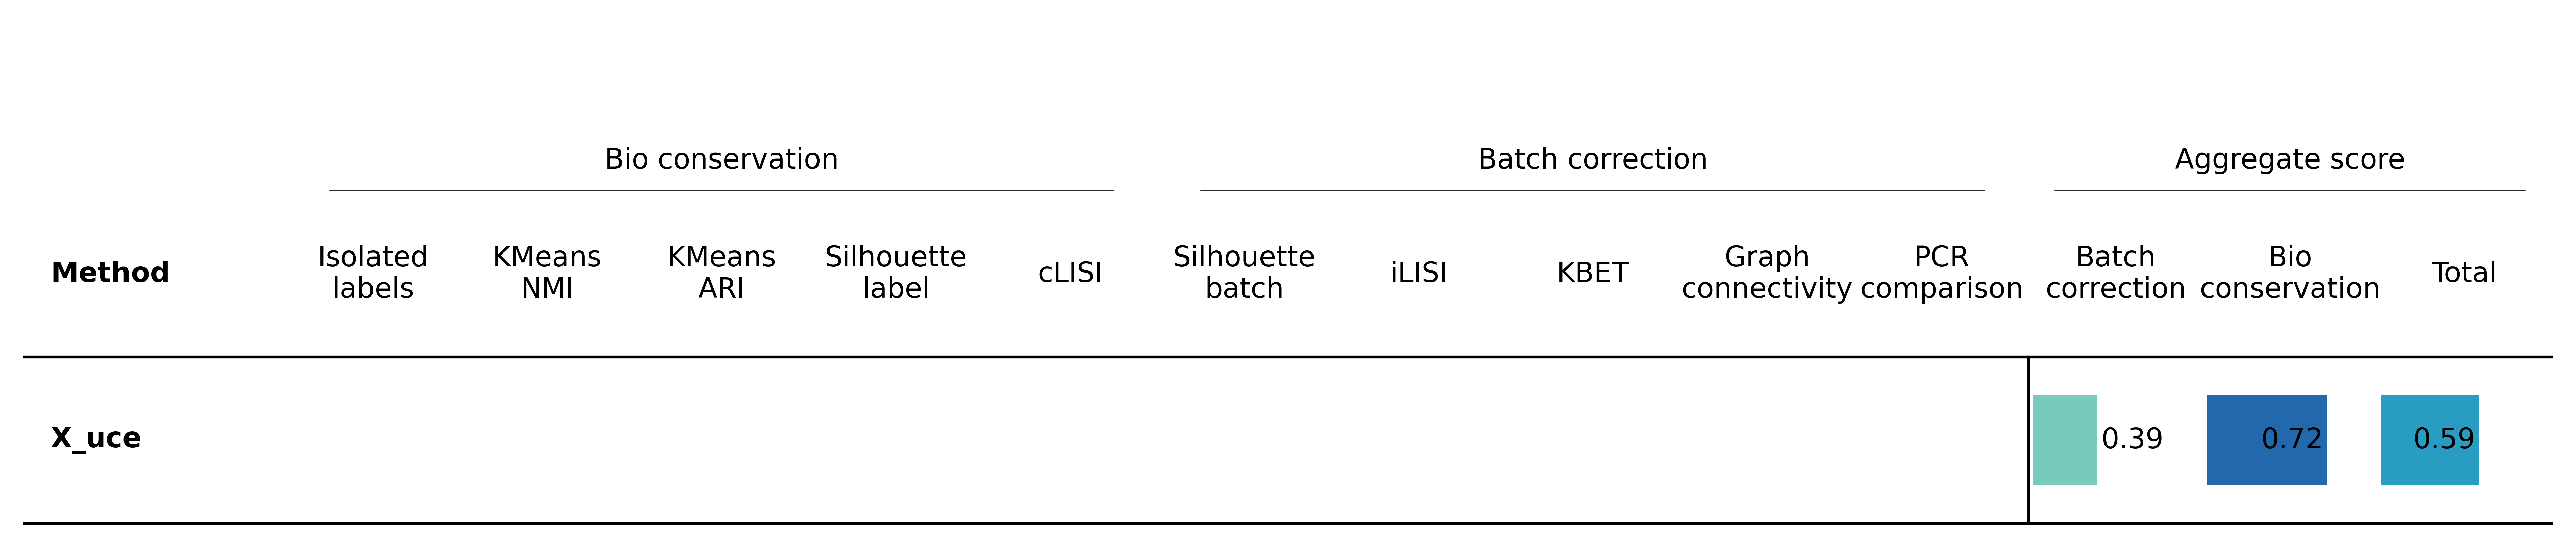

In [79]:
bm_uce.plot_results_table(min_max_scale=False, save_dir='figures')

In [47]:
bm_uce.__dict__

{'_adata': AnnData object with n_obs × n_vars = 61774 × 15646
     obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability'
     var: 'n_cells-0', 'n_cells-1', 'n_cells'
     uns: 'log1p', 'pca'
     obsm: 'X_uce', 'X_pca'
     varm: 'PCs',
 '_embedding_obsm_keys': ['X_uce'],
 '_pre_integrated_embedding_obsm_key': 'X_pca',
 '_bio_conservation_metrics': BioConservation(isolated_labels=True, nmi_ari_cluster_labels_leiden=False, nmi_ari_cluster_labels_kmeans=True, silhouette_label=True, clisi_knn=True),
 '_batch_correction_metrics': BatchCorrection(silhouette_batch=True, ilisi_knn=True, kbet_per_label=True, graph_connectivity=True, pcr_comparison=True),
 '_results': Embedding                             X_uce       Metric Type
 isolated_labels                     0.66774  Bio conservation
 nmi_ari_cluster_labels_

In [83]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    tm_adata_test,
    batch_key='tech',
    label_key='Celltype',
    embedding_obsm_keys=[SCVI_LATENT_KEY, SCANVI_LATENT_KEY, TM_ZEROSHOT_KEY, PCA_LATENT_KEY],
    n_jobs=-1
)
bm.benchmark()

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:42<02:06, 42.28s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [01:31<01:32, 46.43s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [02:13<00:44, 44.53s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:51<00:00, 42.81s/it]


In [84]:
bm.__dict__

{'_adata': AnnData object with n_obs × n_vars = 61774 × 20116
     obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability', '_scvi_batch', '_scvi_labels', 'kmeans_pca', 'kmeans_clusters', 'leiden_clusters'
     var: 'n_cells-0', 'n_cells-1'
     uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'pca', 'Celltype_colors', 'tech_colors', 'celltype_tech_availability_colors', 'leiden_clusters'
     obsm: 'X_scVI', 'X_umap', 'X_pca', 'X_VICReg_zeroshot_v3_5_latent', 'X_scANVI'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 '_embedding_obsm_keys': ['X_scVI',
  'X_scANVI',
  'X_VICReg_zeroshot_v3_5_latent',
  'X_pca'],
 '_pre_integrated_embedding_obsm_key': 'X_pca',
 '_bio_conservation_metrics': BioConservation(isolated_labels=True, nmi_ari_cluster_labels_leiden

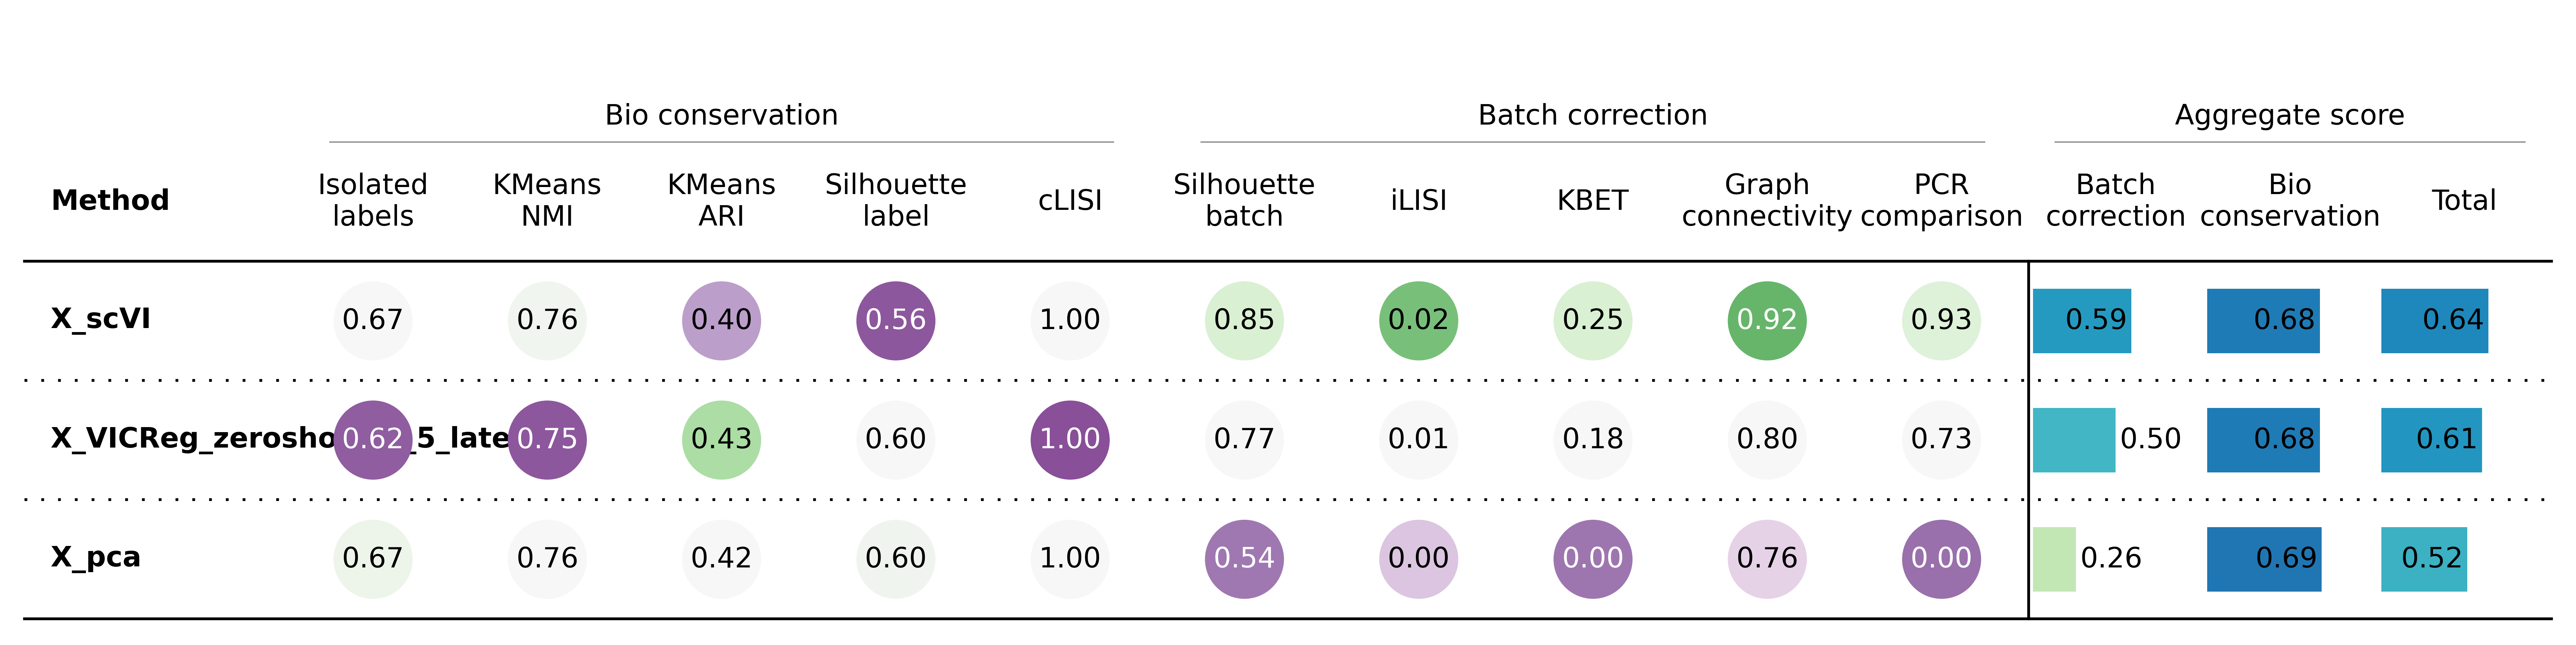

In [80]:
bm.plot_results_table(min_max_scale=False)

### HiRES Comparisons

#### Zero-shot

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# v3,5
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_gRS_gSS_epoch=112-val_loss=0.4803.ckpt' # best
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent50_ctCS_ctmsgG_DO_ctRS_gSS_epoch=97-val_loss=0.3729.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_gRS_ctRS_gSS_epoch=98-val_loss=7.9260.ckpt'

# v3,5 ExpanderLarge
# checkpoint_path=r'VICRegExpanderLarge_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=743-val_loss=8.7914.ckpt'
# checkpoint_path=r'VICRegExpanderLarge_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=145-val_loss=9.9619.ckpt'
# v4_zeroshot_VICReg_model = scRNASeqE_VICRegExpanderLarge.load_from_checkpoint(checkpoint_path=checkpoint_path)

# v3,5 Expander
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=938-val_loss=7.2107.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_gG_ctmsgG_DO_ctRS_gSS_epoch=71-val_loss=22.2740 copy.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_gG_ctmsgG_DO_ctRS_gSS_epoch=632-val_loss=16.9918.ckpt'
checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=8.8825.ckpt'
v4_zeroshot_VICReg_model = scRNASeqE_VICRegExpander.load_from_checkpoint(checkpoint_path=checkpoint_path)


# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_latent128_ctCS_ctmsgG_DO_ctRS_gSS_epoch=199-val_loss=0.3237.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=0.5817.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_gRS_gSS_epoch=157-val_loss=1.0068.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_ctRS_gSS_epoch=91-val_loss=1.2750.ckpt' #hummingbird

# v4_zeroshot_VICReg_model = scRNASeqE_VICReg.load_from_checkpoint(checkpoint_path=checkpoint_path)
v4_zeroshot_VICReg_model.to(device)
v4_zeroshot_VICReg_model.eval()

In [78]:
embryo_adata_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned.pkl'
with open(embryo_adata_path, 'rb') as f:
    embryo_adata = pickle.load(f)  

embryo_dataset_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned_dataset.pkl'
with open(embryo_dataset_path, 'rb') as f:
    embryo_dataset = pickle.load(f)  

brain_adata_path = data_dir / 'pickled' / 'HiRES' / 'brain_adata_tm_aligned.pkl'
with open(brain_adata_path, 'rb') as f:
    brain_adata = pickle.load(f) 

embryo_adata = embryo_adata.copy()
brain_adata = brain_adata.copy()

In [238]:
with torch.no_grad():
    latent_representations_embryo = v4_zeroshot_VICReg_model.encoder(
        torch.tensor(embryo_adata.X, dtype=torch.float32).to(device)
        )
latent_np_encoder = latent_representations_embryo.cpu().numpy()
EMBRYO_ZEROSHOT_KEY = 'X_VICReg_v4_zeroshot'
embryo_adata.obsm[EMBRYO_ZEROSHOT_KEY] = latent_np_encoder

sc.pp.neighbors(embryo_adata, use_rep=EMBRYO_ZEROSHOT_KEY)  # Compute neighbors using latent space
sc.tl.umap(embryo_adata, min_dist=0.3)  # Run UMAP

In [239]:
output_folder = r'./create_figures/figures_v3,5/expander/scContrast/HiRES_embryo'
os.makedirs(output_folder, exist_ok=True)

fig = sc.pl.umap(embryo_adata, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/zeroshot_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Stage', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/zeroshot_stages.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Cellcycle phase', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/zeroshot_phases.png')
# plt.close(fig)

# sc.pl.umap(embryo_adata, color='Celltype', size=15)
# sc.pl.umap(embryo_adata, color='Stage', size=15)
# sc.pl.umap(embryo_adata, color='Cellcycle phase', size=15)

In [240]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print('embryo adata')
sil_score_true = silhouette_score(embryo_adata.obsm[EMBRYO_ZEROSHOT_KEY], embryo_adata.obs["Celltype"])
print(f"Silhouette Score ({EMBRYO_ZEROSHOT_KEY}): {sil_score_true:.4f}")

n_clusters = len(embryo_adata.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
embryo_adata.obs["kmeans_clusters"] = kmeans.fit_predict(embryo_adata.obsm[EMBRYO_ZEROSHOT_KEY]).astype(str)
sc.pp.neighbors(embryo_adata, use_rep=EMBRYO_ZEROSHOT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(embryo_adata, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = embryo_adata.obs["Celltype"].values  # True cell types
predicted_labels = embryo_adata.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for {EMBRYO_ZEROSHOT_KEY} Clustering: {ari_score:.4f}")

#### Blind Fine-tune

In [170]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_latent128_ctCS_ctmsgG_DO_ctRS_gSS_epoch=199-val_loss=0.3237.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=0.5817.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_gRS_gSS_epoch=157-val_loss=1.0068.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_ctRS_gSS_epoch=91-val_loss=1.2750.ckpt' #hummingbird

# checkpoint_path=r'VICReg_experiments/best_trial_results/v3/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=177-val_loss=0.4375.ckpt'
'''
# checkpoint_path=r'/users/wli115/data/rsingh47/wli115/scGrapHiCv2/VICRegLarge_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_latent128_ctCS_ctmsgG_DO_ctRS_gSS_epoch=297-val_loss=0.4038.ckpt'
# v4_blind_ft_VICReg_model = scRNASeqE_VICRegLarge.load_from_checkpoint(checkpoint_path=checkpoint_path)
'''
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_gRS_gSS_epoch=112-val_loss=0.4803.ckpt' #best
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent50_ctCS_ctmsgG_DO_ctRS_gSS_epoch=97-val_loss=0.3729.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_ctCS_ctmsgG_DO_ctRS_gSS_epoch=99-val_loss=1.4199.ckpt'
# v3_5_blind_ft_VICReg_model = scRNASeqE_VICReg.load_from_checkpoint(checkpoint_path=checkpoint_path)

# v3,5 Expander
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=938-val_loss=7.2107.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_gG_ctmsgG_DO_ctRS_gSS_epoch=71-val_loss=22.2740 copy.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch512_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=13-val_loss=14.1495.ckpt'
checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=8.8825.ckpt'

v3_5_blind_ft_VICReg_model = scRNASeqE_VICRegExpander.load_from_checkpoint(checkpoint_path=checkpoint_path)
v3_5_blind_ft_VICReg_model.to(device)
v3_5_blind_ft_VICReg_model.eval()

In [171]:
embryo_adata_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned.pkl'
with open(embryo_adata_path, 'rb') as f:
    embryo_adata = pickle.load(f)  

embryo_dataset_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned_dataset.pkl'
with open(embryo_dataset_path, 'rb') as f:
    embryo_dataset = pickle.load(f)  

embryo_train_dataloader = DataLoader(
    embryo_dataset,
    batch_size=2048,
    shuffle=True
)

brain_adata_path = data_dir / 'pickled' / 'HiRES' / 'brain_adata_tm_aligned.pkl'
with open(brain_adata_path, 'rb') as f:
    brain_adata = pickle.load(f) 

embryo_adata = embryo_adata.copy()
brain_adata = brain_adata.copy()
precomputed_dir = data_dir / 'pickled' / 'HiRES' / 'precomputed'
precomputed_gene_clusters_path =  precomputed_dir / 'embryo_adata_tm_aligned_gene_clusters.pkl'
precomputed_mu_sigma_path = precomputed_dir / 'embryo_adata_tm_aligned_mu_sigma.pkl'
with open(precomputed_gene_clusters_path, 'rb') as f:
    precomputed_gene_clusters = pickle.load(f)

with open(precomputed_mu_sigma_path, 'rb') as f:
    precomputed_mu_sigma = pickle.load(f)

for k, v in precomputed_gene_clusters.items():
    globals()[k] = v

for k, v in precomputed_mu_sigma.items():
    globals()[k] = v

In [172]:
from augmentations import *
augmentations_pipeline = [
    # {
    #     'fn': global_per_gene_shuffle,
    #     'needs_cell_types': False,
    #     'kwargs': {}
    # },
    # {
    #     'fn': global_per_gene_gaussian,
    #     'needs_cell_types': False,
    #     'kwargs': lambda model: {'sigma_fill': model.sigma_fill}
    # }, 
    {
        'fn': dropout_augmentation,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_DO}
    },
    {
        'fn': global_random_scaling_augmentation,
        'needs_cell_types': False,
        'kwargs': {}
    },
    {
        'fn': global_gene_subsample,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_gSS}
    },
]

In [173]:
print(f'{v3_5_blind_ft_VICReg_model.dropout_rate_DO=}')
print(f'{v3_5_blind_ft_VICReg_model.dropout_rate_gSS=}')
print(f'{v3_5_blind_ft_VICReg_model.sigma_fill=}')

In [174]:
v3_5_blind_ft_VICReg_model.cell_type_mu_sigma=cell_type_mu_sigma
v3_5_blind_ft_VICReg_model.global_mu_sigma=global_mu_sigma
v3_5_blind_ft_VICReg_model.cell_type_msg_mu_sigma=cell_type_msg_mu_sigma
v3_5_blind_ft_VICReg_model.cell_type_lsg_mu_sigma=cell_type_lsg_mu_sigma
v3_5_blind_ft_VICReg_model.most_significant_genes_dict=most_significant_genes_dict
v3_5_blind_ft_VICReg_model.least_significant_genes_dict=least_significant_genes_dict
v3_5_blind_ft_VICReg_model.gene_networks=gene_networks
v3_5_blind_ft_VICReg_model.gene_names=gene_names
v3_5_blind_ft_VICReg_model.code_to_celltype=code_to_celltype
v3_5_blind_ft_VICReg_model.celltype_to_code=celltype_to_code
v3_5_blind_ft_VICReg_model.gene_name_to_index=gene_name_to_index
v3_5_blind_ft_VICReg_model.index_to_gene_name=index_to_gene_name
v3_5_blind_ft_VICReg_model.gene_dispersions=gene_dispersions
v3_5_blind_ft_VICReg_model.augmentations_pipeline=augmentations_pipeline

v3_5_blind_ft_VICReg_model.sim_weight = 25.0
v3_5_blind_ft_VICReg_model.var_weight = 25.0
v3_5_blind_ft_VICReg_model.cov_weight = 1.0

# v3_5_blind_ft_VICReg_model.sigma_fill = 0.1
v3_5_blind_ft_VICReg_model.dropout_rate_DO = 0.7
v3_5_blind_ft_VICReg_model.dropout_rate_gSS = 0.3

In [175]:
early_stop = pl.callbacks.EarlyStopping('train_loss_vicreg', patience=4)
tm_trained_hires_finetuned = Trainer(
    max_epochs=50,
    precision='bf16-mixed',
    callbacks=[early_stop],
)
tm_trained_hires_finetuned.fit(v3_5_blind_ft_VICReg_model, train_dataloaders=embryo_train_dataloader)

v3_5_blind_ft_VICReg_model.eval()

In [246]:
len(tm_adata_test.obs['tissue'].unique().tolist())


In [244]:
from pytorch_lightning.utilities.model_summary import summarize

summarize(v3_5_blind_ft_VICReg_model)

In [226]:
# After training, get the latent space representations
latent_representations = v3_5_blind_ft_VICReg_model.encoder(torch.tensor(embryo_adata.X, dtype=torch.float32))

# Convert to numpy and visualize with UMAP (or t-SNE)
latent_np = latent_representations.detach().numpy()

BLIND_FT_KEY = 'X_blind_ft_VICReg_v3_5_model_ft_all_tissues_model_latent'
embryo_adata.obsm[BLIND_FT_KEY] = latent_np  # This will store the latents in the obsm dictionary

# Alternatively, if you want to keep the original structure:
# embryo_adata.layers['latent'] = latent_np  # Store as a layer if you need to keep the original data

# Use Scanpy to compute UMAP
sc.pp.neighbors(embryo_adata, use_rep=BLIND_FT_KEY)  # Compute neighbors using latent space
sc.tl.umap(embryo_adata)  # Run UMAP

In [227]:
output_folder = r'./create_figures/figures_v3,5/expander/scContrast/HiRES_embryo'
os.makedirs(output_folder, exist_ok=True)

fig = sc.pl.umap(embryo_adata, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/blind_finetune_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Stage', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/blind_finetune_stages.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Cellcycle phase', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
# fig.savefig(f'{output_folder}/blind_finetune_phases.png')
# plt.close(fig)

# fig = sc.pl.umap(embryo_adata, color='Stage', return_fig=True, size=30)

In [178]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print('embryo adata, blind')
sil_score_true = silhouette_score(embryo_adata.obsm[BLIND_FT_KEY], embryo_adata.obs["Celltype"])
print(f"Silhouette Score ({BLIND_FT_KEY}): {sil_score_true:.4f}")

n_clusters = len(embryo_adata.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
embryo_adata.obs["kmeans_clusters"] = kmeans.fit_predict(embryo_adata.obsm[BLIND_FT_KEY]).astype(str)
sc.pp.neighbors(embryo_adata, use_rep=BLIND_FT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(embryo_adata, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = embryo_adata.obs["Celltype"].values  # True cell types
predicted_labels = embryo_adata.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for {BLIND_FT_KEY} Clustering: {ari_score:.4f}")



In [160]:
plot_legend_only(embryo_adata, 'Celltype', f'{output_folder}/celltypes_legend.png', ncols=2)
plot_legend_only(embryo_adata, 'Stage', f'{output_folder}/stages_legend.png')
plot_legend_only(embryo_adata, 'Cellcycle phase', f'{output_folder}/phases_legend.png')

##### Forgetting?

In [228]:
# After training, get the latent space representations
latent_representations = v3_5_blind_ft_VICReg_model.encoder(torch.tensor(tm_adata_test.X.toarray(), dtype=torch.float32))

# Convert to numpy and visualize with UMAP (or t-SNE)
latent_np = latent_representations.detach().numpy()

tm_adata_test.obsm[BLIND_FT_KEY] = latent_np  # This will store the latents in the obsm dictionary

# Alternatively, if you want to keep the original structure:
# embryo_adata.layers['latent'] = latent_np  # Store as a layer if you need to keep the original data

# Use Scanpy to compute UMAP
sc.pp.neighbors(tm_adata_test, use_rep=BLIND_FT_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

In [229]:
fig = sc.pl.umap(tm_adata_test, color='Celltype', return_fig=True, size=30)
fig = sc.pl.umap(tm_adata_test, color='tech', return_fig=True, size=30)
fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', return_fig=True, size=30)

#### Informed Fine-tune

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_latent128_ctCS_ctmsgG_DO_ctRS_gSS_epoch=199-val_loss=0.3237.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=0.5817.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_gRS_gSS_epoch=157-val_loss=1.0068.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_ctRS_gSS_epoch=91-val_loss=1.2750.ckpt' #hummingbird

# checkpoint_path=r'VICReg_experiments/best_trial_results/v3/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=177-val_loss=0.4375.ckpt'
'''
# checkpoint_path=r'/users/wli115/data/rsingh47/wli115/scGrapHiCv2/VICRegLarge_experiments/best_trial_results/v4/checkpoints/genes20116_batch8192_latent128_ctCS_ctmsgG_DO_ctRS_gSS_epoch=297-val_loss=0.4038.ckpt'
# v4_blind_ft_VICReg_model = scRNASeqE_VICRegLarge.load_from_checkpoint(checkpoint_path=checkpoint_path)
'''
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_gRS_gSS_epoch=112-val_loss=0.4803.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent50_ctCS_ctmsgG_DO_ctRS_gSS_epoch=97-val_loss=0.3729.ckpt'

# v3,5 Expander
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=938-val_loss=7.2107.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_gG_ctmsgG_DO_ctRS_gSS_epoch=71-val_loss=22.2740 copy.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch512_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=13-val_loss=14.1495.ckpt'
checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=8.8825.ckpt'

v4_informed_ft_VICReg_model = scRNASeqE_VICRegExpander.load_from_checkpoint(checkpoint_path=checkpoint_path)

# v4_informed_ft_VICReg_model = scRNASeqE_VICReg.load_from_checkpoint(checkpoint_path=checkpoint_path)
v4_informed_ft_VICReg_model.to(device)
v4_informed_ft_VICReg_model.eval()

In [38]:
embryo_adata_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned.pkl'
with open(embryo_adata_path, 'rb') as f:
    embryo_adata = pickle.load(f)  

embryo_dataset_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned_dataset.pkl'
with open(embryo_dataset_path, 'rb') as f:
    embryo_dataset = pickle.load(f)  

embryo_train_dataloader = DataLoader(
    embryo_dataset,
    batch_size=1024,
    shuffle=True
)

brain_adata_path = data_dir / 'pickled' / 'HiRES' / 'brain_adata_tm_aligned.pkl'
with open(brain_adata_path, 'rb') as f:
    brain_adata = pickle.load(f) 

embryo_adata = embryo_adata.copy()
brain_adata = brain_adata.copy()
precomputed_dir = data_dir / 'pickled' / 'HiRES' / 'precomputed'
precomputed_gene_clusters_path =  precomputed_dir / 'embryo_adata_tm_aligned_gene_clusters.pkl'
precomputed_mu_sigma_path = precomputed_dir / 'embryo_adata_tm_aligned_mu_sigma.pkl'
with open(precomputed_gene_clusters_path, 'rb') as f:
    precomputed_gene_clusters = pickle.load(f)

with open(precomputed_mu_sigma_path, 'rb') as f:
    precomputed_mu_sigma = pickle.load(f)

for k, v in precomputed_gene_clusters.items():
    globals()[k] = v

for k, v in precomputed_mu_sigma.items():
    globals()[k] = v

In [225]:
v4_informed_ft_VICReg_model.__dict__.keys()

In [39]:
from augmentations import *
augmentations_pipeline = [
    {
        'fn': per_cell_type_significant_genes_gaussian,
        'needs_cell_types': True,
        'kwargs': lambda model: {
            'gene_dict': model.most_significant_genes_dict, 
            'mu_sigma_dict': model.cell_type_msg_mu_sigma,
            'gene_name_to_index': model.gene_name_to_index, 
            'sigma_value': 1e-1 }
    },
    {
        'fn': dropout_augmentation,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_DO}
    },
    # {
    #     'fn': global_random_scaling_augmentation,
    #     'needs_cell_types': False,
    #     'kwargs': {}
    # },
    {
        'fn': cell_type_specific_scaling_augmentation,
        'needs_cell_types': True,
        'kwargs': {}
    },
    {
        'fn': global_gene_subsample,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_gSS}
    },
]

In [40]:
v4_informed_ft_VICReg_model.cell_type_mu_sigma=cell_type_mu_sigma
v4_informed_ft_VICReg_model.global_mu_sigma=global_mu_sigma
v4_informed_ft_VICReg_model.cell_type_msg_mu_sigma=cell_type_msg_mu_sigma
v4_informed_ft_VICReg_model.cell_type_lsg_mu_sigma=cell_type_lsg_mu_sigma
v4_informed_ft_VICReg_model.most_significant_genes_dict=most_significant_genes_dict
v4_informed_ft_VICReg_model.least_significant_genes_dict=least_significant_genes_dict
v4_informed_ft_VICReg_model.gene_networks=gene_networks
v4_informed_ft_VICReg_model.gene_names=gene_names
v4_informed_ft_VICReg_model.code_to_celltype=code_to_celltype
v4_informed_ft_VICReg_model.celltype_to_code=celltype_to_code
v4_informed_ft_VICReg_model.gene_name_to_index=gene_name_to_index
v4_informed_ft_VICReg_model.index_to_gene_name=index_to_gene_name
v4_informed_ft_VICReg_model.gene_dispersions=gene_dispersions
v4_informed_ft_VICReg_model.augmentations_pipeline=augmentations_pipeline

v4_informed_ft_VICReg_model.sim_weight=25.0
v4_informed_ft_VICReg_model.var_weight=25.0
v4_informed_ft_VICReg_model.cov_weight=1.0

v4_informed_ft_VICReg_model.dropout_rate_DO=0.7
v4_informed_ft_VICReg_model.dropout_rate_gSS=0.3

In [41]:
early_stop = pl.callbacks.EarlyStopping('train_loss_vicreg', patience=4)
tm_trained_hires_finetuned = Trainer(
    max_epochs=50,
    precision='bf16-mixed',
    callbacks=[early_stop],
)
tm_trained_hires_finetuned.fit(v4_informed_ft_VICReg_model, train_dataloaders=embryo_train_dataloader)

v4_informed_ft_VICReg_model.eval()

In [42]:
# After training, get the latent space representations
latent_representations = v4_informed_ft_VICReg_model.encoder(torch.tensor(embryo_adata.X, dtype=torch.float32))

# Convert to numpy and visualize with UMAP (or t-SNE)
latent_np = latent_representations.detach().numpy()

INFORMED_FT_KEY = 'X_informed_ft_VICReg_v4_model_ft_all_tissues_model_latent'
embryo_adata.obsm[INFORMED_FT_KEY] = latent_np  # This will store the latents in the obsm dictionary

# Alternatively, if you want to keep the original structure:
# embryo_adata.layers['latent'] = latent_np  # Store as a layer if you need to keep the original data

# Use Scanpy to compute UMAP
sc.pp.neighbors(embryo_adata, use_rep=INFORMED_FT_KEY)  # Compute neighbors using latent space
sc.tl.umap(embryo_adata)  # Run UMAP

In [43]:
output_folder = r'./create_figures/figures_v3,5/expander/scContrast/HiRES_embryo'
os.makedirs(output_folder, exist_ok=True)

fig = sc.pl.umap(embryo_adata, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/informed_finetune_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Stage', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/informed_finetune_stages.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Cellcycle phase', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/informed_finetune_phases.png')
# plt.close(fig)

# fig = sc.pl.umap(embryo_adata, color='Celltype', return_fig=True)
# fig = sc.pl.umap(embryo_adata, color='Stage', return_fig=True)
# fig = sc.pl.umap(embryo_adata, color='Cellcycle phase', return_fig=True)

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print('embryo adata, informed FT')
sil_score_true = silhouette_score(embryo_adata.obsm[INFORMED_FT_KEY], embryo_adata.obs["Celltype"])
print(f"Silhouette Score ({INFORMED_FT_KEY}): {sil_score_true:.4f}")

n_clusters = len(embryo_adata.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
embryo_adata.obs["kmeans_clusters"] = kmeans.fit_predict(embryo_adata.obsm[INFORMED_FT_KEY]).astype(str)
sc.pp.neighbors(embryo_adata, use_rep=INFORMED_FT_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(embryo_adata, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = embryo_adata.obs["Celltype"].values  # True cell types
predicted_labels = embryo_adata.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for {INFORMED_FT_KEY} Clustering: {ari_score:.4f}")



##### Forgetting?

In [ ]:
# After training, get the latent space representations
latent_representations = v4_informed_ft_VICReg_model.encoder(torch.tensor(tm_adata_test.X.toarray(), dtype=torch.float32))

# Convert to numpy and visualize with UMAP (or t-SNE)
latent_np = latent_representations.detach().numpy()

tm_adata_test.obsm['X_informed_ft_VICReg_v4_model_ft_all_tissues_model_latent'] = latent_np  # This will store the latents in the obsm dictionary

# Alternatively, if you want to keep the original structure:
# embryo_adata.layers['latent'] = latent_np  # Store as a layer if you need to keep the original data

# Use Scanpy to compute UMAP
sc.pp.neighbors(tm_adata_test, use_rep='X_informed_ft_VICReg_v4_model_ft_all_tissues_model_latent')  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

In [ ]:
output_folder = r'./create_figures/figures_v3,5/scContrast'
os.makedirs(output_folder, exist_ok=True)

fig = sc.pl.umap(tm_adata_test, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/tabula_muris/informed_finetune_tm_test_forgetting_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/tabula_muris/informed_finetune_tm_test_forgetting_tech.png')
# plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/tabula_muris/informed_finetune_tm_test_forgetting_availability.png')
# plt.close(fig)

# fig = sc.pl.umap(tm_adata_test, color='Celltype', return_fig=True, size=30)
# fig = sc.pl.umap(tm_adata_test, color='tech', return_fig=True, size=30)
# fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', return_fig=True, size=30)

#### Subsetted Finetune

In [179]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# checkpoint_path=r'qol_experiments/lightning_logs/version_8176453/checkpoints/hvg20116_genes20116_batch512_v3_ctCS_ctmsgG_DO_ctRS_gSS_epoch=65-val_loss=0.8920.ckpt'
# checkpoint_path=r'VICReg_experiments/lightning_logs/version_8181343/checkpoints/genes20116_batch1024_ctCS_ctmsgG_DO_gRS_gSS_epoch=59-val_loss=0.7980_v3.ckpt'
# checkpoint_path=r'VICReg_experiments/best_trial_results/v3/checkpoints/genes20116_batch4096_ctCS_ctmsgG_DO_ctRS_gSS_epoch=177-val_loss=0.4375.ckpt'

# checkpoint_path=r'VICReg_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_ctCS_ctmsgG_DO_gRS_gSS_epoch=112-val_loss=0.4803.ckpt'
# subsetted_hires_ft_VICReg_model = scRNASeqE_VICReg.load_from_checkpoint(checkpoint_path=checkpoint_path)

# v3,5 Expander
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=938-val_loss=7.2107.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_gG_ctmsgG_DO_ctRS_gSS_epoch=71-val_loss=22.2740 copy.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch512_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=13-val_loss=14.1495.ckpt'
# checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent64_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=968-val_loss=5.7642.ckpt'
checkpoint_path=r'VICRegExpander_experiments/best_trial_results/v3,5/checkpoints/genes20116_batch8192_latent128_fixed_loss_ctCS_ctmsgG_DO_ctRS_gSS_epoch=152-val_loss=8.8825.ckpt'

subsetted_hires_ft_VICReg_model = scRNASeqE_VICRegExpander.load_from_checkpoint(checkpoint_path=checkpoint_path)


subsetted_hires_ft_VICReg_model.to(device)

In [180]:
embryo_adata_path = data_dir / 'pickled' / 'HiRES' / 'embryo_adata_tm_aligned.pkl'
with open(embryo_adata_path, 'rb') as f:
    embryo_adata = pickle.load(f)


brain_adata_path = data_dir / 'pickled' / 'HiRES' / 'brain_adata_tm_aligned.pkl'
with open(brain_adata_path, 'rb') as f:
    brain_adata = pickle.load(f) 

embryo_adata = embryo_adata.copy()
brain_adata = brain_adata.copy()

##### Limited Stages

In [181]:
embryo_stages = embryo_adata.obs['Stage'].unique().tolist()
limited_stages = ['E70', 'E75', 'E80', 'E85']

In [182]:
embryo_stages

In [183]:
limited_stages_embryo_adata = embryo_adata[
    (embryo_adata.obs['Stage'].isin(limited_stages))
    ]
celltype_counts = limited_stages_embryo_adata.obs['Celltype'].value_counts()
valid_cell_types = celltype_counts[celltype_counts >= 2].index.tolist()
limited_stages_embryo_adata = limited_stages_embryo_adata[
    limited_stages_embryo_adata.obs['Celltype'].isin(valid_cell_types)
]

In [185]:
limited_stages_embryo_dataset = AnnDataDataset(limited_stages_embryo_adata)
limited_stages_embryo_dataloader = DataLoader(limited_stages_embryo_dataset, batch_size=2048)

In [186]:
# Precompute data-dependent variables before model initialization
(most_significant_genes_dict, least_significant_genes_dict,
 gene_networks, gene_names, code_to_celltype, celltype_to_code,
 gene_name_to_index, index_to_gene_name, gene_dispersions) = precompute_gene_clusters(limited_stages_embryo_dataset)

cell_type_mu_sigma, global_mu_sigma, cell_type_msg_mu_sigma, cell_type_lsg_mu_sigma = precompute_mu_sigma(
    limited_stages_embryo_dataloader, most_significant_genes_dict, least_significant_genes_dict, gene_name_to_index)

In [187]:
from augmentations import *

augmentations_pipeline = [
    # {
    #     'fn': per_cell_type_significant_genes_gaussian,
    #     'needs_cell_types': True,
    #     'kwargs': lambda model: {
    #         'gene_dict': model.most_significant_genes_dict, 
    #         'mu_sigma_dict': model.cell_type_msg_mu_sigma,
    #         'gene_name_to_index': model.gene_name_to_index, 
    #         'sigma_value': 1e-1 }
    # },
    # {
    #     'fn': global_per_gene_gaussian,
    #     'needs_cell_types': False,
    #     'kwargs': lambda model: {'sigma_fill': model.sigma_fill}
    # }, 
    {
        'fn': dropout_augmentation,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_DO}
    },
    {
        'fn': global_random_scaling_augmentation,
        'needs_cell_types': False,
        'kwargs': {}
    },
    # {
    #     'fn': cell_type_specific_scaling_augmentation,
    #     'needs_cell_types': True,
    #     'kwargs': {}
    # },
    {
        'fn': global_gene_subsample,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_gSS}
    },
]

In [188]:
subsetted_hires_ft_VICReg_model.cell_type_mu_sigma=cell_type_mu_sigma
subsetted_hires_ft_VICReg_model.global_mu_sigma=global_mu_sigma
subsetted_hires_ft_VICReg_model.cell_type_msg_mu_sigma=cell_type_msg_mu_sigma
subsetted_hires_ft_VICReg_model.cell_type_lsg_mu_sigma=cell_type_lsg_mu_sigma
subsetted_hires_ft_VICReg_model.most_significant_genes_dict=most_significant_genes_dict
subsetted_hires_ft_VICReg_model.least_significant_genes_dict=least_significant_genes_dict
subsetted_hires_ft_VICReg_model.gene_networks=gene_networks
subsetted_hires_ft_VICReg_model.gene_names=gene_names
subsetted_hires_ft_VICReg_model.code_to_celltype=code_to_celltype
subsetted_hires_ft_VICReg_model.celltype_to_code=celltype_to_code
subsetted_hires_ft_VICReg_model.gene_name_to_index=gene_name_to_index
subsetted_hires_ft_VICReg_model.index_to_gene_name=index_to_gene_name
# subsetted_hires_ft_VICReg_model.gene_dispersions=gene_dispersions
subsetted_hires_ft_VICReg_model.gene_dispersions=None

subsetted_hires_ft_VICReg_model.augmentations_pipeline=augmentations_pipeline
subsetted_hires_ft_VICReg_model.sim_weight = 25.0
subsetted_hires_ft_VICReg_model.var_weight = 25.0
subsetted_hires_ft_VICReg_model.cov_weight = 1.0

# v3_5_blind_ft_VICReg_model.sigma_fill = 0.1
subsetted_hires_ft_VICReg_model.dropout_rate_DO = 0.7
subsetted_hires_ft_VICReg_model.dropout_rate_gSS = 0.3
subsetted_hires_ft_VICReg_model.sigma_fill = 0.1

In [189]:
early_stop = pl.callbacks.EarlyStopping('train_loss_vicreg', patience=4)
tm_trained_hires_finetuned = Trainer(
    max_epochs=100,
    precision='bf16-mixed',
    callbacks=[early_stop],
)
tm_trained_hires_finetuned.fit(subsetted_hires_ft_VICReg_model, train_dataloaders=limited_stages_embryo_dataloader)
# tm_trained_hires_finetuned.fit(subsetted_hires_ft_VICReg_model, train_dataloaders=limited_celltypes_embryo_dataloader)

subsetted_hires_ft_VICReg_model.eval()

In [190]:
# After training, get the latent space representations
latent_representations = subsetted_hires_ft_VICReg_model.encoder(torch.tensor(embryo_adata.X, dtype=torch.float32))

# Convert to numpy and visualize with UMAP (or t-SNE)
latent_np = latent_representations.detach().numpy()

BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY = 'X_VICReg_subsetted_hires_ft_VICReg_model_latent'
embryo_adata.obsm[BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY] = latent_np  # This will store the latents in the obsm dictionary

# Alternatively, if you want to keep the original structure:
# embryo_adata.layers['latent'] = latent_np  # Store as a layer if you need to keep the original data

# Use Scanpy to compute UMAP
sc.pp.neighbors(embryo_adata, use_rep=BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY)  # Compute neighbors using latent space
sc.tl.umap(embryo_adata)  # Run UMAP

In [191]:
output_folder = r'./create_figures/figures_v3,5/expander/scContrast/HiRES_embryo'
os.makedirs(output_folder, exist_ok=True)

fig = sc.pl.umap(embryo_adata, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/subsetted_stage_blind_finetune_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Stage', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/subsetted_stage_blind_finetune_stages.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Cellcycle phase', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/subsetted_stage_blind_finetune_phases.png')
# plt.close(fig)

# fig = sc.pl.umap(embryo_adata, color='Celltype', return_fig=True)
# # fig.savefig(f'./qol_experiments/figures/ft100_batch1024_ctRS_v3_tm_train_celltypes_2.png')
# fig = sc.pl.umap(embryo_adata, color='Stage', return_fig=True)
# # fig.savefig(f'./qol_experiments/figures/ft100_batch1024_ctRS_v3_tm_train_tech_2.png')

In [192]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Compute Silhouette
print('embryo adata, informed FT')
sil_score_true = silhouette_score(embryo_adata.obsm[BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY], embryo_adata.obs["Celltype"])
print(f"Silhouette Score ({BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY}): {sil_score_true:.4f}")

n_clusters = len(embryo_adata.obs["Celltype"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
embryo_adata.obs["kmeans_clusters"] = kmeans.fit_predict(embryo_adata.obsm[BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY]).astype(str)
sc.pp.neighbors(embryo_adata, use_rep=BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY)  # use_rep tells Scanpy to use your embedding
sc.tl.leiden(embryo_adata, resolution=1.0, key_added="leiden_clusters")  # Run Leiden clustering
true_labels = embryo_adata.obs["Celltype"].values  # True cell types
predicted_labels = embryo_adata.obs["kmeans_clusters"].values  # Use "leiden_clusters" if you chose Leiden

# Compute ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI for {BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY} Clustering: {ari_score:.4f}")



##### Forgetting?

In [230]:
# After training, get the latent space representations
latent_representations = subsetted_hires_ft_VICReg_model.encoder(torch.tensor(tm_adata_test.X.toarray(), dtype=torch.float32))

# Convert to numpy and visualize with UMAP (or t-SNE)
latent_np = latent_representations.detach().numpy()

tm_adata_test.obsm[BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY] = latent_np  # This will store the latents in the obsm dictionary

# Alternatively, if you want to keep the original structure:
# embryo_adata.layers['latent'] = latent_np  # Store as a layer if you need to keep the original data

# Use Scanpy to compute UMAP
sc.pp.neighbors(tm_adata_test, use_rep=BLIND_FT_STAGE_SUBSETTED_EMBRYO_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

In [231]:
fig = sc.pl.umap(tm_adata_test, color='Celltype', return_fig=True, size=50)
fig = sc.pl.umap(tm_adata_test, color='tech', return_fig=True, size=50)
fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', return_fig=True, size=50)

##### Limited Cell-Types

In [ ]:
import random
embryo_celltypes = embryo_adata.obs['Celltype'].unique().tolist()
limited_celltypes = random.sample(embryo_celltypes, len(embryo_celltypes)//2)

In [ ]:
limited_celltypes_embryo_adata = embryo_adata[
    (embryo_adata.obs['Celltype'].isin(limited_celltypes))
    ]
celltype_counts = limited_celltypes_embryo_adata.obs['Celltype'].value_counts()
valid_cell_types = celltype_counts[celltype_counts >= 2].index.tolist()
limited_celltypes_embryo_adata = limited_celltypes_embryo_adata[
    limited_celltypes_embryo_adata.obs['Celltype'].isin(valid_cell_types)
]

In [ ]:
limited_celltypes_embryo_dataset = AnnDataDataset(limited_celltypes_embryo_adata)
limited_celltypes_embryo_dataloader = DataLoader(limited_celltypes_embryo_dataset, batch_size=128)

In [ ]:
# Precompute data-dependent variables before model initialization
(most_significant_genes_dict, least_significant_genes_dict,
 gene_networks, gene_names, code_to_celltype, celltype_to_code,
 gene_name_to_index, index_to_gene_name, gene_dispersions) = precompute_gene_clusters(limited_celltypes_embryo_dataset)

cell_type_mu_sigma, global_mu_sigma, cell_type_msg_mu_sigma, cell_type_lsg_mu_sigma = precompute_mu_sigma(
    limited_celltypes_embryo_dataloader, most_significant_genes_dict, least_significant_genes_dict, gene_name_to_index)

In [ ]:
from augmentations import *
augmentations_pipeline = [
    {
        'fn': per_cell_type_significant_genes_gaussian,
        'needs_cell_types': True,
        'kwargs': lambda model: {
            'gene_dict': model.most_significant_genes_dict, 
            'mu_sigma_dict': model.cell_type_msg_mu_sigma,
            'gene_name_to_index': model.gene_name_to_index, 
            'sigma_value': 1e-1 }
    },
    {
        'fn': dropout_augmentation,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_DO}
    },
    # {
    #     'fn': global_random_scaling_augmentation,
    #     'needs_cell_types': False,
    #     'kwargs': {}
    # },
    {
        'fn': cell_type_specific_scaling_augmentation,
        'needs_cell_types': True,
        'kwargs': {}
    },
    {
        'fn': global_gene_subsample,
        'needs_cell_types': False,
        'kwargs': lambda model: {'dropout_rate': model.dropout_rate_gSS}
    },
]

In [ ]:
subsetted_hires_ft_VICReg_model.cell_type_mu_sigma=cell_type_mu_sigma
subsetted_hires_ft_VICReg_model.global_mu_sigma=global_mu_sigma
subsetted_hires_ft_VICReg_model.cell_type_msg_mu_sigma=cell_type_msg_mu_sigma
subsetted_hires_ft_VICReg_model.cell_type_lsg_mu_sigma=cell_type_lsg_mu_sigma
subsetted_hires_ft_VICReg_model.most_significant_genes_dict=most_significant_genes_dict
subsetted_hires_ft_VICReg_model.least_significant_genes_dict=least_significant_genes_dict
subsetted_hires_ft_VICReg_model.gene_networks=gene_networks
subsetted_hires_ft_VICReg_model.gene_names=gene_names
subsetted_hires_ft_VICReg_model.code_to_celltype=code_to_celltype
subsetted_hires_ft_VICReg_model.celltype_to_code=celltype_to_code
subsetted_hires_ft_VICReg_model.gene_name_to_index=gene_name_to_index
subsetted_hires_ft_VICReg_model.index_to_gene_name=index_to_gene_name
subsetted_hires_ft_VICReg_model.gene_dispersions=gene_dispersions

subsetted_hires_ft_VICReg_model.augmentations_pipeline=augmentations_pipeline

In [ ]:
early_stop = pl.callbacks.EarlyStopping('train_loss_vicreg', patience=4)
tm_trained_hires_finetuned = Trainer(
    max_epochs=50,
    precision='bf16-mixed',
    callbacks=[early_stop],
)
tm_trained_hires_finetuned.fit(subsetted_hires_ft_VICReg_model, train_dataloaders=limited_celltypes_embryo_dataloader)
# tm_trained_hires_finetuned.fit(subsetted_hires_ft_VICReg_model, train_dataloaders=limited_celltypes_embryo_dataloader)

subsetted_hires_ft_VICReg_model.eval()

In [ ]:
# After training, get the latent space representations
latent_representations = subsetted_hires_ft_VICReg_model.encoder(torch.tensor(embryo_adata.X, dtype=torch.float32))

# Convert to numpy and visualize with UMAP (or t-SNE)
latent_np = latent_representations.detach().numpy()

embryo_adata.obsm['X_VICReg_subsetted_celltypes_hires_ft_VICReg_model_latent'] = latent_np  # This will store the latents in the obsm dictionary

# Alternatively, if you want to keep the original structure:
# embryo_adata.layers['latent'] = latent_np  # Store as a layer if you need to keep the original data

# Use Scanpy to compute UMAP
sc.pp.neighbors(embryo_adata, use_rep='X_VICReg_subsetted_celltypes_hires_ft_VICReg_model_latent')  # Compute neighbors using latent space
sc.tl.umap(embryo_adata)  # Run UMAP

In [ ]:
print(f'{limited_celltypes=}')
output_folder = r'./create_figures/figures_v3,5/scContrast/HiRES_embryo'
os.makedirs(output_folder, exist_ok=True)

fig = sc.pl.umap(embryo_adata, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/subsetted_celltypes_finetune_celltypes.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Stage', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/subsetted_celltypes_finetune_stages.png')
# plt.close(fig)

fig = sc.pl.umap(embryo_adata, color='Cellcycle phase', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/subsetted_celltypes_finetune_phases.png')
# plt.close(fig)

# fig = sc.pl.umap(embryo_adata, color='Celltype', return_fig=True)
# # fig.savefig(f'./qol_experiments/figures/ft100_batch1024_ctRS_v3_tm_train_celltypes_2.png')
# fig = sc.pl.umap(embryo_adata, color='Stage', return_fig=True)
# # fig.savefig(f'./qol_experiments/figures/ft100_batch1024_ctRS_v3_tm_train_tech_2.png')